In [1]:
from kitaev import *
from tqdm import tqdm
from scipy.misc import derivative as dif
from scipy.integrate import quad
plt.style.use(["default",'seaborn-v0_8-poster','normal_font.mplstyle'])
from math import floor, ceil
import matplotlib as mp

In [2]:
from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import Trapezoid, Simpson, Boole, MonteCarlo, VEGAS # The available integrators
from torchquad.utils.set_precision import set_precision
import torchquad

In [3]:
# Use this to enable GPU support and set the floating point precision
set_up_backend("torch", data_type="float32")

/home/eslam/.local/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [4]:
def winding_number(_h,gamma,trapz = True, k_steps = 200):
    _var_k = torch.linspace(-np.pi,np.pi,k_steps)
    #_y =lambda k: (-1j/(4*math.pi))*torch.trace(gamma@la.inv(_h(k))@(dif(_h,k,dx=1/k_steps)),dim1=1, dim2=2)
    _y =lambda k: (-1j/(4*math.pi))*torch.diagonal(gamma@la.inv(_h(k))@(dif(_h,k,dx=1/k_steps)),offset=0,dim1=-2, dim2=-1).sum(-1)
    #print(_y(_var_k))
    if trapz:
        #return np.trapz([_y(k).cpu().numpy() for k in _var_k],_var_k.cpu().numpy())
        tp = Trapezoid()
        return tp.integrate(_y, dim=1, N=k_steps, integration_domain=[[-math.pi,math.pi]])
    else:
        _yreal = lambda k: np.real(_y(k))
        _yimag = lambda k: np.imag(_y(k))
        real_integral = quad(_yreal,-np.pi,np.pi)
        imag_integral = quad(_yimag,-np.pi,np.pi)
        return np.array(real_integral[0] + 1j*imag_integral[0])

In [17]:
def winding_number(_h,gamma,trapz = True, k_steps = 200):
    # Compute the expression for multiple 'k' steps using broadcasting
    _y =lambda k: (-1j / (4 * math.pi)) * torch.einsum('ikj,ij,ikj->i', gamma, la.inv(_h(k)), (dif(_h,k,dx=1/k_steps)))
    _var_k = torch.linspace(-np.pi,np.pi,k_steps)
    print(_y(_var_k))
    if trapz:
        #return np.trapz([_y(k).cpu().numpy() for k in _var_k],_var_k.cpu().numpy())
        tp = Trapezoid()
        return tp.integrate(_y, dim=1, N=k_steps, integration_domain=[[-math.pi,math.pi]])

In [5]:
#var_mu = np.linspace(0.1,11,50)
var_T = np.linspace(0.2, 5, 251)
var_w = np.linspace(-1.2,1.2,241)
#var_T = np.linspace(0.2, 5, 51)
#var_w = np.linspace(-1.2,1.2,49)
#var_w = [0]
#var_w = np.linspace(-1.2,1.2,49)
#var_w = np.linspace(-0.2,2.2,49)
windings1 = []
windings2 = []
#windings1pi = []
#windings2pi = []

t = torch.tensor(1.0)
N_global = 50
d_global = 2
mu1 = 0* t 
mu2 = 3 * t 
delta1 = 1 * t 
delta2 = 1 * t 
t1 = 1 * t 
t2 = 1 * t
h_1 = Hamiltonian(d=d_global, N=N_global, u=onsite(_mu=mu1), v=offsite(_delta=delta1, _t=t1))
h_2 = Hamiltonian(d=d_global, N=N_global, u=onsite(_mu=mu2), v=offsite(_delta=delta2, _t=t2))
delta_amount =  0.001 #1E-5
for T in tqdm(var_T):
    winding1 = []
    winding2 = []
    #winding1pi = []
    #winding2pi = []
    for w in var_w:
        flq_kitv_k1 = lambda k: floquet_hamiltonian2([(3/4)*h_2.k_space_hamiltonian(k), (3/2)*h_1.k_space_hamiltonian(k),(3/4)*h_2.k_space_hamiltonian(k)], T=T)
        flq_kitv_k2 = lambda k: floquet_hamiltonian2([(3/4)*h_1.k_space_hamiltonian(k), (3/2)*h_2.k_space_hamiltonian(k),(3/4)*h_1.k_space_hamiltonian(k)], T=T)
        #w = np.mod(w + 1, 2 * 1) - 1
        #w = np.mod(w , 2 * 1) -1
        
        a = lambda k: (w - delta_amount * 1j)*torch.eye(d_global) - flq_kitv_k1(k)
        b = lambda k: (w - delta_amount * 1j)*torch.eye(d_global) - flq_kitv_k2(k)

        w1 = winding_number(a,s_x,k_steps=300,trapz=True)
        w2 = winding_number(b,s_x,k_steps=300,trapz=True)
        winding1.append(w1.cpu().numpy())
        winding2.append(w2.cpu().numpy())
        '''
        flq_kitv_k1pi = lambda k: (np.abs(w) + delta_amount * 1j-1)*np.eye(d_global) - floquet_hamiltonian2([(3/4)*h_2.k_space_hamiltonian(k), (3/2)*h_1.k_space_hamiltonian(k),(3/4)*h_2.k_space_hamiltonian(k)], T=T)
        flq_kitv_k2pi = lambda k: (np.abs(w) + delta_amount * 1j-1)*np.eye(d_global) - floquet_hamiltonian2([(3/4)*h_1.k_space_hamiltonian(k), (3/2)*h_2.k_space_hamiltonian(k),(3/4)*h_1.k_space_hamiltonian(k)], T=T)
        w1pi = winding_number(flq_kitv_k1pi,s_x,k_steps=20,trapz=True)
        w2pi = winding_number(flq_kitv_k2pi,s_x,k_steps=20,trapz=True)
        winding1pi.append(w1pi)
        winding2pi.append(w2pi)
        '''
    windings1.append(winding1)
    windings2.append(winding2)
    #windings1pi.append(winding1pi)
    #windings2pi.append(winding2pi)

windings1 = np.array(windings1)
windings2 = np.array(windings2)

#windings1pi = np.array(windings1pi)
#windings2pi = np.array(windings2pi)


  0%|          | 0/251 [00:00<?, ?it/s]

c:\Users\eslam\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\eslam\AppData\Local\Temp\ipykernel_16724\262094734.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  _y =lambda k: (-1j/(4*math.pi))*torch.diagonal(gamma@la.inv(_h(k))@(dif(_h,k,dx=1/k_steps)),offset=0,dim1=-2, dim2=-1).sum(-1)
c:\Users\eslam\anaconda3\Lib\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
100%|█████████

In [ ]:
print(np.mod(var_w +1, 2 * 1)-1)

In [6]:
#np.save(f'sbbc_windings1_mu={mu2},small delta = {delta_amount},k_steps=300.npy',windings1)
#np.save(f'sbbc_windings2_mu={mu2},small delta = {delta_amount},k_steps=300.npy',windings2)
#windings1 = np.load('sbbc_windings1_mu=3.npy')
#windings2 = np.load('sbbc_windings2_mu=3.npy')

In [ ]:
#a = np.load('sbbc_windings1_mu=6.5.npy')
#b = np.load('sbbc_windings2_mu=6.5.npy')



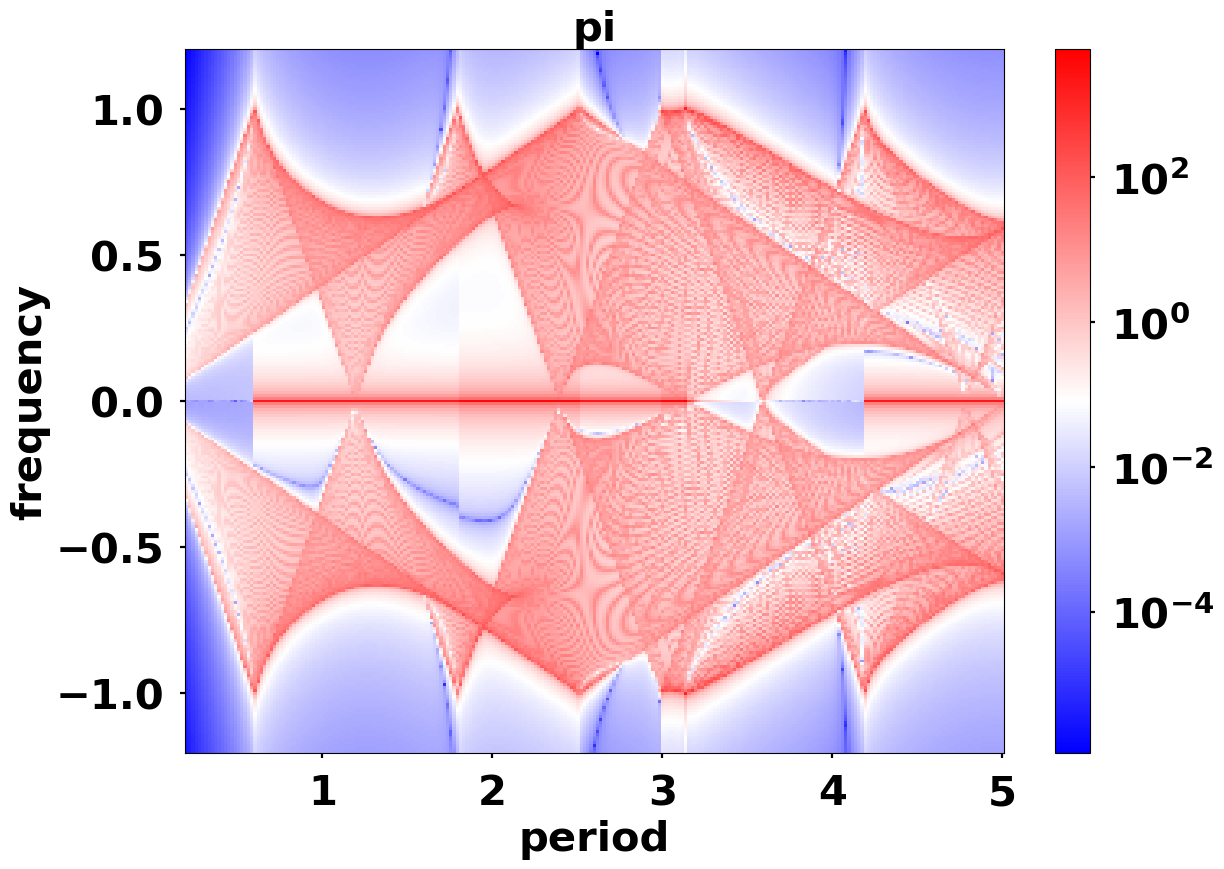

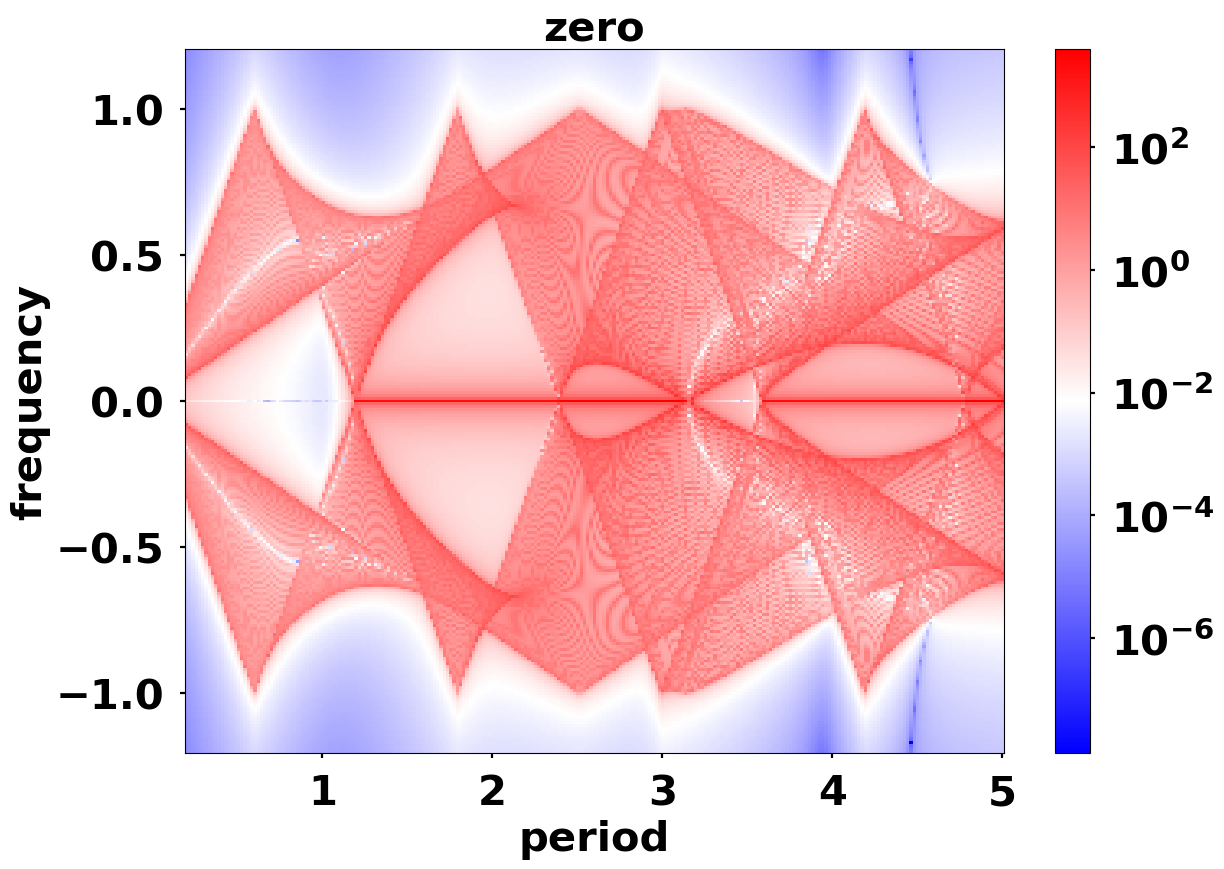

In [31]:
_n = 8/2
x, y = np.meshgrid(var_T, var_w)
windings2dzero = np.zeros((len(var_w),len(var_T)))
windings2dpi = np.zeros((len(var_w),len(var_T)))
for i in range(len(var_T)):
    for j in range(len(var_w)):
        windings2dzero[j,i] = ((windings1+windings2)[i,j]/(var_w[j]+delta_amount*1j)).imag
        windings2dpi[j,i] = ((windings2-windings1)[i,j]/(np.abs(var_w[j])+delta_amount*1j)).imag

'''
        if np.abs(windings2dzero[j,i]) > _n:
            windings2dzero[j,i] = floor(windings2dzero[j-1,i])
        
        if np.abs(windings2dpi[j,i]) > _n:
            windings2dpi[j,i] = floor(windings2dzero[j-1,i])
'''



fig = plt.figure()
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

cp = plt.pcolormesh(x, y, np.abs(((windings2dpi))), cmap='bwr',norm='log')
plt.colorbar(cp)

ax.set_title('pi')
ax.set_xlabel('period')
ax.set_ylabel('frequency')
#plt.savefig('winding number of pi majorana vs period and delta, delta = hopping, mu1=0, mu2=1.pdf',bbox_inches = 'tight')
plt.show()




fig = plt.figure()
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

cp = plt.pcolormesh(x, y, np.abs(((windings2dzero))), cmap='bwr',norm='log')
plt.colorbar(cp)

ax.set_title('zero')
ax.set_xlabel('period')
ax.set_ylabel('frequency')
#plt.savefig('winding number of pi majorana vs period and delta, delta = hopping, mu1=0, mu2=1.pdf',bbox_inches = 'tight')
plt.show()

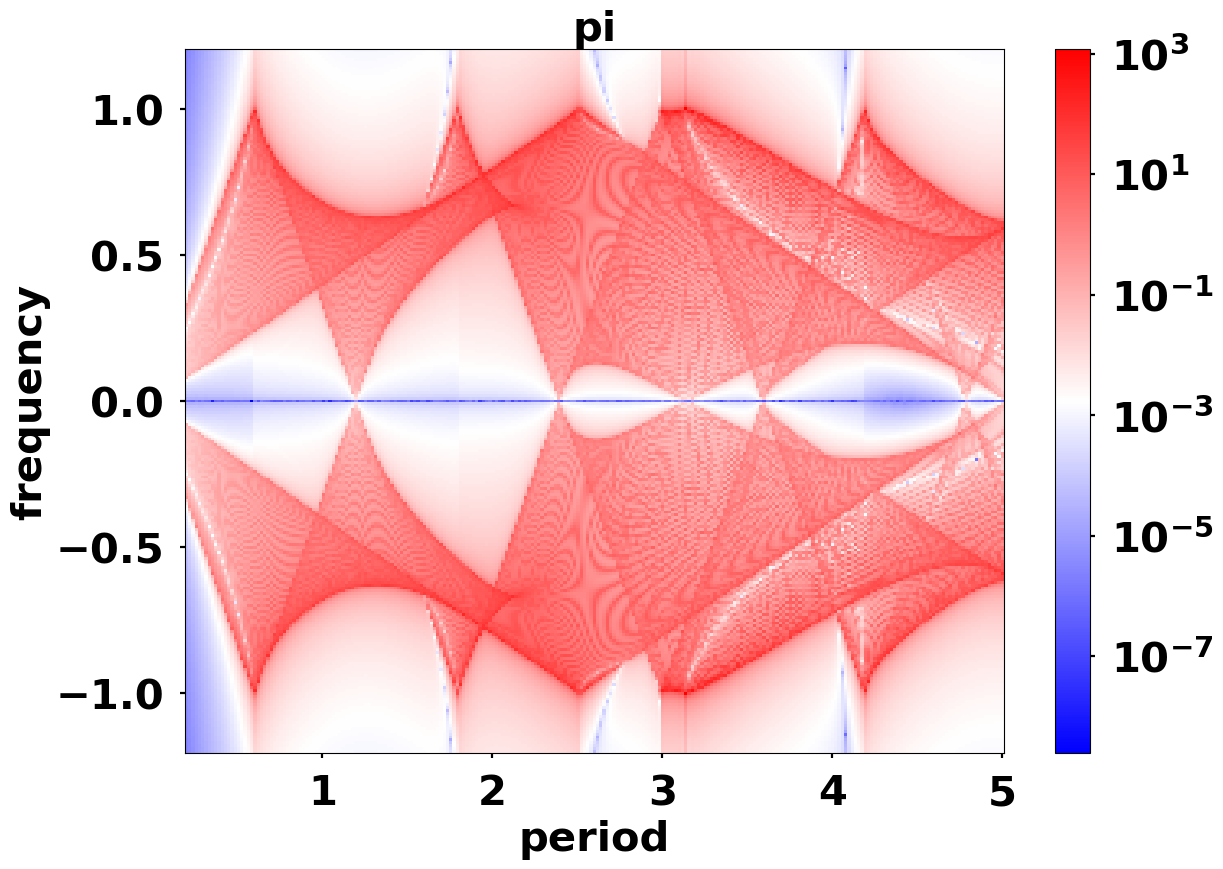

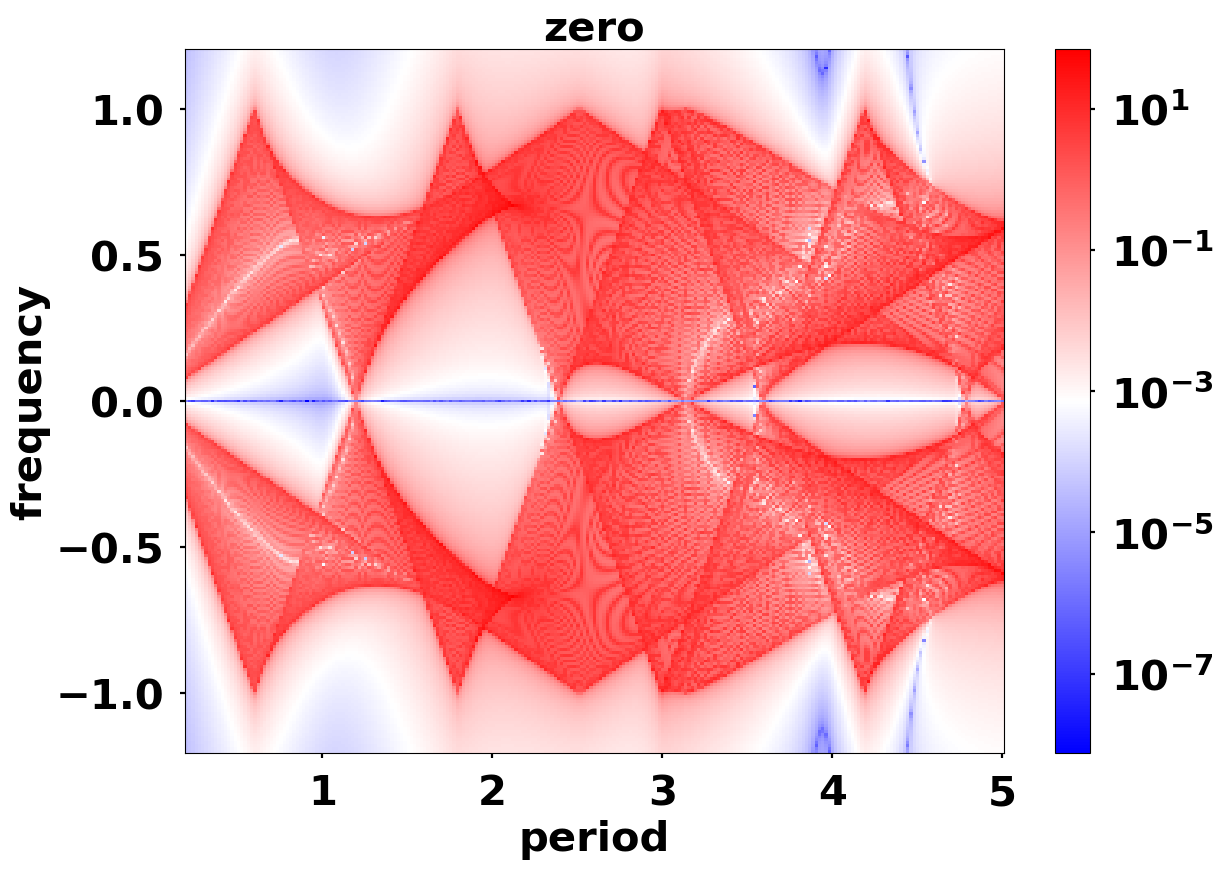

In [32]:
_n = 8/2
x, y = np.meshgrid(var_T, var_w)
windings2dzero = np.zeros((len(var_w),len(var_T)))
windings2dpi = np.zeros((len(var_w),len(var_T)))
for i in range(len(var_T)):
    for j in range(len(var_w)):
        windings2dzero[j,i] = ((windings1+windings2)[i,j]).imag
        windings2dpi[j,i] = ((windings2-windings1)[i,j]).imag

'''
        if np.abs(windings2dzero[j,i]) > _n:
            windings2dzero[j,i] = floor(windings2dzero[j-1,i])
        
        if np.abs(windings2dpi[j,i]) > _n:
            windings2dpi[j,i] = floor(windings2dzero[j-1,i])
'''



fig = plt.figure()
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

cp = plt.pcolormesh(x, y, np.abs(((windings2dpi))), cmap='bwr',norm='log')
plt.colorbar(cp)

ax.set_title('pi')
ax.set_xlabel('period')
ax.set_ylabel('frequency')
#plt.savefig('winding number of pi majorana vs period and delta, delta = hopping, mu1=0, mu2=1.pdf',bbox_inches = 'tight')
plt.show()




fig = plt.figure()
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

cp = plt.pcolormesh(x, y, np.abs(((windings2dzero))), cmap='bwr',norm='log')
plt.colorbar(cp)

ax.set_title('zero')
ax.set_xlabel('period')
ax.set_ylabel('frequency')
#plt.savefig('winding number of pi majorana vs period and delta, delta = hopping, mu1=0, mu2=1.pdf',bbox_inches = 'tight')
plt.show()

In [33]:
_n = 8/2
x, y = np.meshgrid(var_T, var_w)
windings2dzero = np.zeros((len(var_w),len(var_T)))
windings2dpi = np.zeros((len(var_w),len(var_T)))
for i in range(len(var_T)):
    for j in range(len(var_w)):
        windings2dzero[j,i] = ((a+b)[i,j]).imag
        windings2dpi[j,i] = ((b-a)[i,j]).imag

'''
        if np.abs(windings2dzero[j,i]) > _n:
            windings2dzero[j,i] = floor(windings2dzero[j-1,i])
        
        if np.abs(windings2dpi[j,i]) > _n:
            windings2dpi[j,i] = floor(windings2dzero[j-1,i])
'''



fig = plt.figure()
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

cp = plt.pcolormesh(x, y, np.abs(((windings2dpi))), cmap='bwr',norm='log')
plt.colorbar(cp)

ax.set_title('pi')
ax.set_xlabel('period')
ax.set_ylabel('frequency')
#plt.savefig('winding number of pi majorana vs period and delta, delta = hopping, mu1=0, mu2=1.pdf',bbox_inches = 'tight')
plt.show()




fig = plt.figure()
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

cp = plt.pcolormesh(x, y, np.abs(((windings2dzero))), cmap='bwr',norm='log')
plt.colorbar(cp)

ax.set_title('zero')
ax.set_xlabel('period')
ax.set_ylabel('frequency')
#plt.savefig('winding number of pi majorana vs period and delta, delta = hopping, mu1=0, mu2=1.pdf',bbox_inches = 'tight')
plt.show()

TypeError: unsupported operand type(s) for +: 'function' and 'function'

In [4]:
var_mu = np.linspace(0.1,8,251)
var_T = np.linspace(0.2, 2.5*np.pi, 251)

windings1 = []
windings2 = []

t = torch.tensor(1.0)
N_global = 50
d_global = 2
delta1 = 1 * t 
delta2 = 1 * t 
t1 = 1 * t 
t2 = 1 * t
for m in tqdm(var_mu):
    mu1 = 0* t 
    mu2 = m * t 
    h_1 = Hamiltonian(d=d_global, N=N_global, u=onsite(_mu=mu1), v=offsite(_delta=delta1, _t=t1))
    h_2 = Hamiltonian(d=d_global, N=N_global, u=onsite(_mu=mu2), v=offsite(_delta=delta2, _t=t2))
    delta_amount =  0.001 #1E-5
    winding1 = []
    winding2 = []
    for T in (var_T):
        flq_kitv_k1 = lambda k: floquet_hamiltonian2([(3/4)*h_2.k_space_hamiltonian(k), (3/2)*h_1.k_space_hamiltonian(k),(3/4)*h_2.k_space_hamiltonian(k)], T=T)
        flq_kitv_k2 = lambda k: floquet_hamiltonian2([(3/4)*h_1.k_space_hamiltonian(k), (3/2)*h_2.k_space_hamiltonian(k),(3/4)*h_1.k_space_hamiltonian(k)], T=T)
        
        
        w1 = winding_number(flq_kitv_k1,s_x,k_steps=300,trapz=True)
        w2 = winding_number(flq_kitv_k2,s_x,k_steps=300,trapz=True)
        winding1.append(w1.cpu().numpy())
        winding2.append(w2.cpu().numpy())
        
    windings1.append(winding1)
    windings2.append(winding2)
    
windings1 = np.array(windings1)
windings2 = np.array(windings2)

#windings1pi = np.array(windings1pi)
#windings2pi = np.array(windings2pi)


  0%|          | 0/251 [00:00<?, ?it/s]


NameError: name 'winding_number' is not defined

In [8]:
windings1 = np.load("windings1_mu2 vs T, mu1=0, small delta = 0.001,k_steps=300.npy")
windings2 = np.load("windings2_mu2 vs T, mu1=0, small delta = 0.001,k_steps=300.npy")
var_mu = np.linspace(0.1,8,251)
var_T = np.linspace(0.2, 2.5*np.pi, 251)

In [9]:
print(windings1.shape)

(251, 251)


C:\Users\eslam\AppData\Local\Temp\ipykernel_21864\1341709865.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  windings2dzero[j,i] = ((windings1+windings2)[i,j]/2)
C:\Users\eslam\AppData\Local\Temp\ipykernel_21864\1341709865.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  windings2dpi[j,i] = ((windings2-windings1)[i,j]/2)
C:\Users\eslam\AppData\Local\Temp\ipykernel_21864\1341709865.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mp.cm.get_cmap('Accent',6)


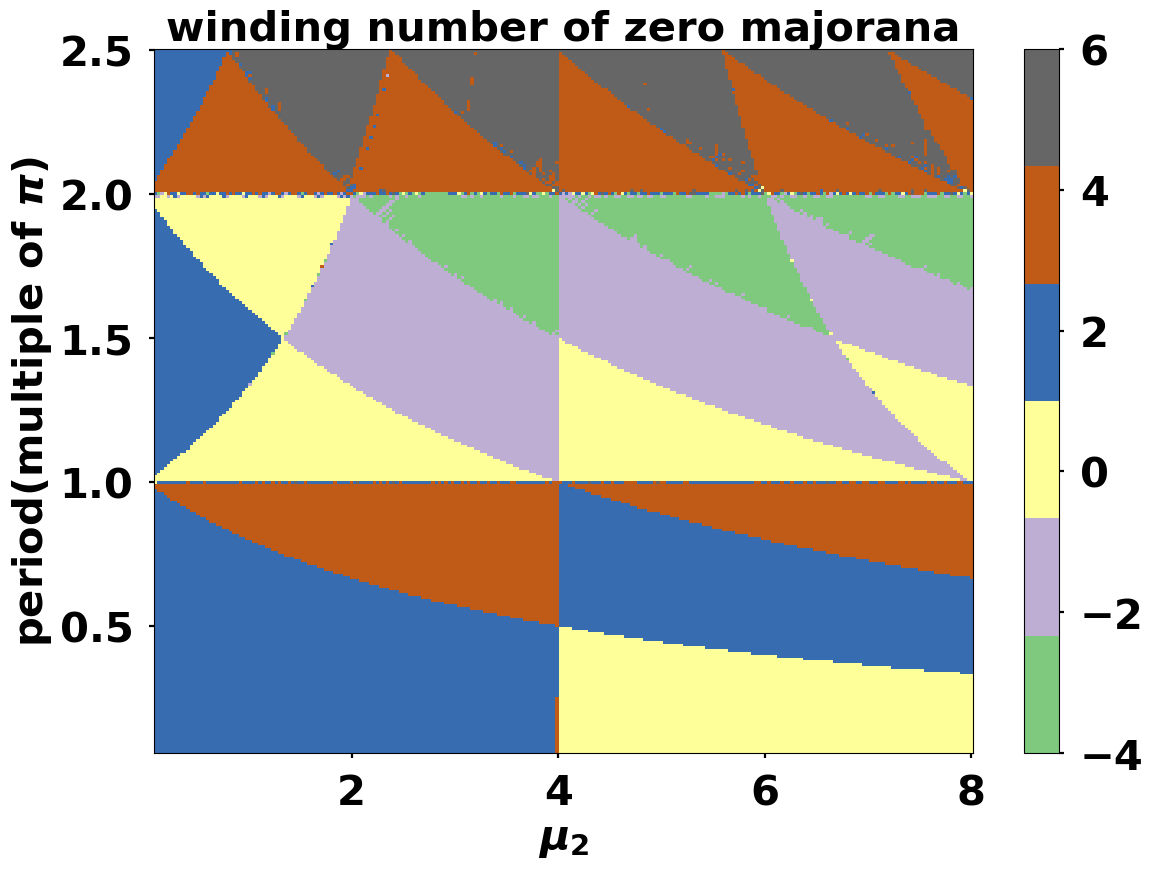

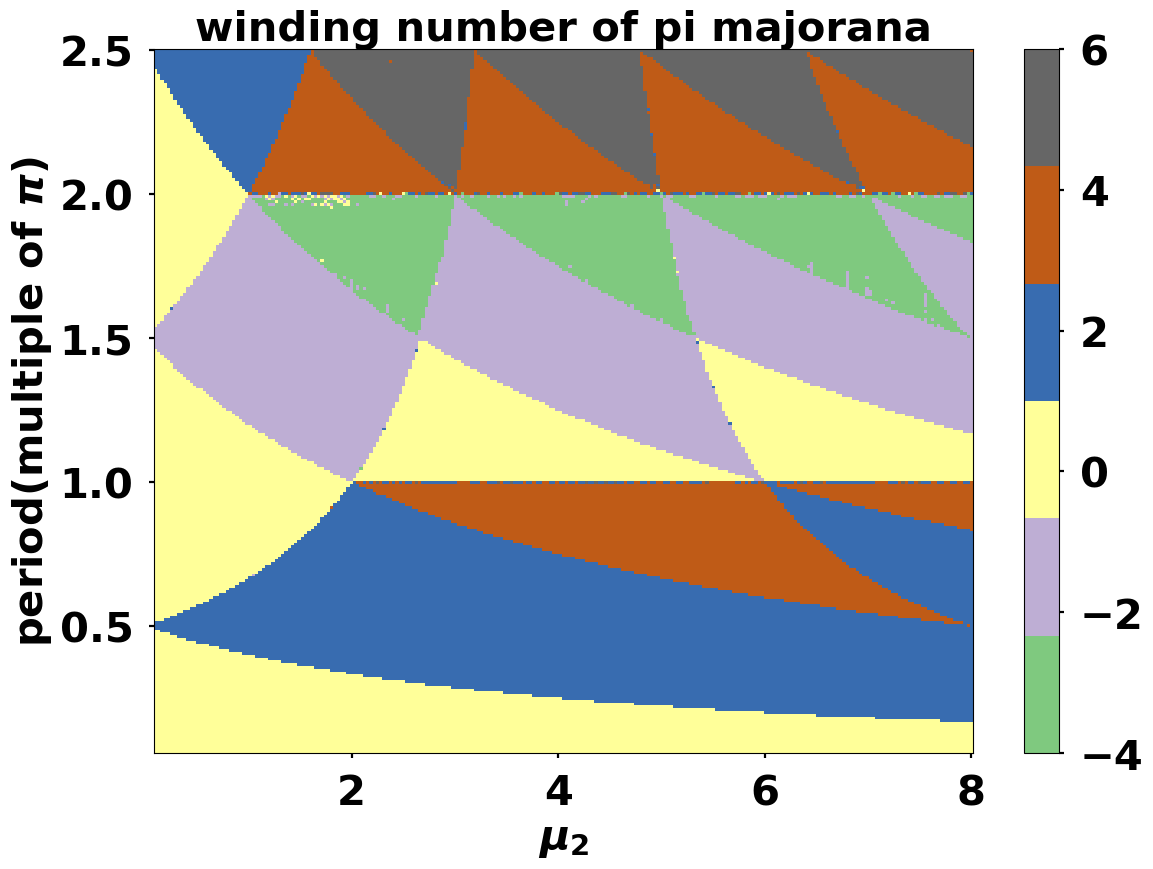

In [19]:
_n = 8/2
x, y = np.meshgrid(var_mu, var_T)
windings2dzero = np.zeros((len(var_T),len(var_mu)))
windings2dpi = np.zeros((len(var_T),len(var_mu)))
for i in range(len(var_mu)):
    for j in range(len(var_T)):
        windings2dzero[j,i] = ((windings1+windings2)[i,j]/2)
        windings2dpi[j,i] = ((windings2-windings1)[i,j]/2)


        if (windings2dzero[j,i]) > 3 or (windings2dzero[j,i]) < -2:
            windings2dzero[j,i] = floor(windings2dzero[j-1,i-1])
        
        if (windings2dpi[j,i]) > 3 or (windings2dpi[j,i]) < -2:
            windings2dpi[j,i] = floor(windings2dzero[j-1,i-1])






fig = plt.figure()
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
cmap = mp.cm.get_cmap('Accent',6)
cp = plt.pcolormesh(x, y/np.pi, (np.round((windings2dzero))*2), cmap=cmap)
plt.colorbar(cp)

ax.set_title('winding number of zero majorana')
ax.set_xlabel('$\mu_2$')
ax.set_ylabel('period(multiple of $\pi$)')
plt.savefig(f'winding number of zero majorana vs mu2, mu1={mu1},delta1={delta1},delta2={delta2}.pdf',bbox_inches = 'tight')
plt.show()



fig = plt.figure()
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

cp = plt.pcolormesh(x, y/np.pi, (np.round((windings2dpi))*2), cmap=cmap)
plt.colorbar(cp)

ax.set_title('winding number of pi majorana')
ax.set_xlabel('$\mu_2$')
ax.set_ylabel('period(multiple of $\pi$)')
plt.savefig(f'winding number of pi majorana vs mu2, mu1={mu1},delta1={delta1},delta2={delta2}.pdf',bbox_inches = 'tight')
plt.show()

In [ ]:
#np.save(f'windings1_mu2 vs T, mu1=0, small delta = {delta_amount},k_steps=300.npy',windings1)
#np.save(f'windings2_mu2 vs T, mu1=0, small delta = {delta_amount},k_steps=300.npy',windings2)

In [5]:
#var_mu = np.linspace(0.1,11,50)
var_mu = [0.5,1,3,6.5]
var_T = np.linspace(0.2, 2.5*np.pi, 251)
var_Delta = np.linspace(0,3,50)
windings1 = []
windings2 = []

for i in tqdm(range(len(var_mu))):
    t=1
    N_global = 50
    d_global = 2
    mu1 = 0* t 
    mu2 = var_mu[i] * t 
    delta1 = 1 * t 
    delta2 = 1 * t 
    t1 = 1 * t 
    t2 = 1 * t
    h_1 = Hamiltonian(d=d_global, N=N_global, u=onsite(_mu=mu1), v=offsite(_delta=delta1, _t=t1))
    h_2 = Hamiltonian(d=d_global, N=N_global, u=onsite(_mu=mu2), v=offsite(_delta=delta2, _t=t2))

    winding1 = []
    winding2 = []

    for j in range(len(var_T)):
        
        flq_kitv_k1 = lambda k: floquet_hamiltonian2([(3/4)*h_2.k_space_hamiltonian(k), (3/2)*h_1.k_space_hamiltonian(k),(3/4)*h_2.k_space_hamiltonian(k)], T=var_T[j])
        flq_kitv_k2 = lambda k: floquet_hamiltonian2([(3/4)*h_1.k_space_hamiltonian(k), (3/2)*h_2.k_space_hamiltonian(k),(3/4)*h_1.k_space_hamiltonian(k)], T=var_T[j])

        w1 = winding_number(flq_kitv_k1,s_x,k_steps=2000,trapz=True)
        w2 = winding_number(flq_kitv_k2,s_x,k_steps=2000,trapz=True)
        winding1.append(w1.cpu().numpy())
        winding2.append(w2.cpu().numpy())
    
    windings1.append(winding1)
    windings2.append(winding2)

windings1 = np.array(windings1)
windings2 = np.array(windings2)


  0%|          | 0/4 [00:00<?, ?it/s]/home/eslam/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_2332985/262094734.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  _y =lambda k: (-1j/(4*math.pi))*torch.diagonal(gamma@la.inv(_h(k))@(dif(_h,k,dx=1/k_steps)),offset=0,dim1=-2, dim2=-1).sum(-1)
/home/eslam/.local/lib/python3.10/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
100%|██████████| 4/4 [00

/home/eslam/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/eslam/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


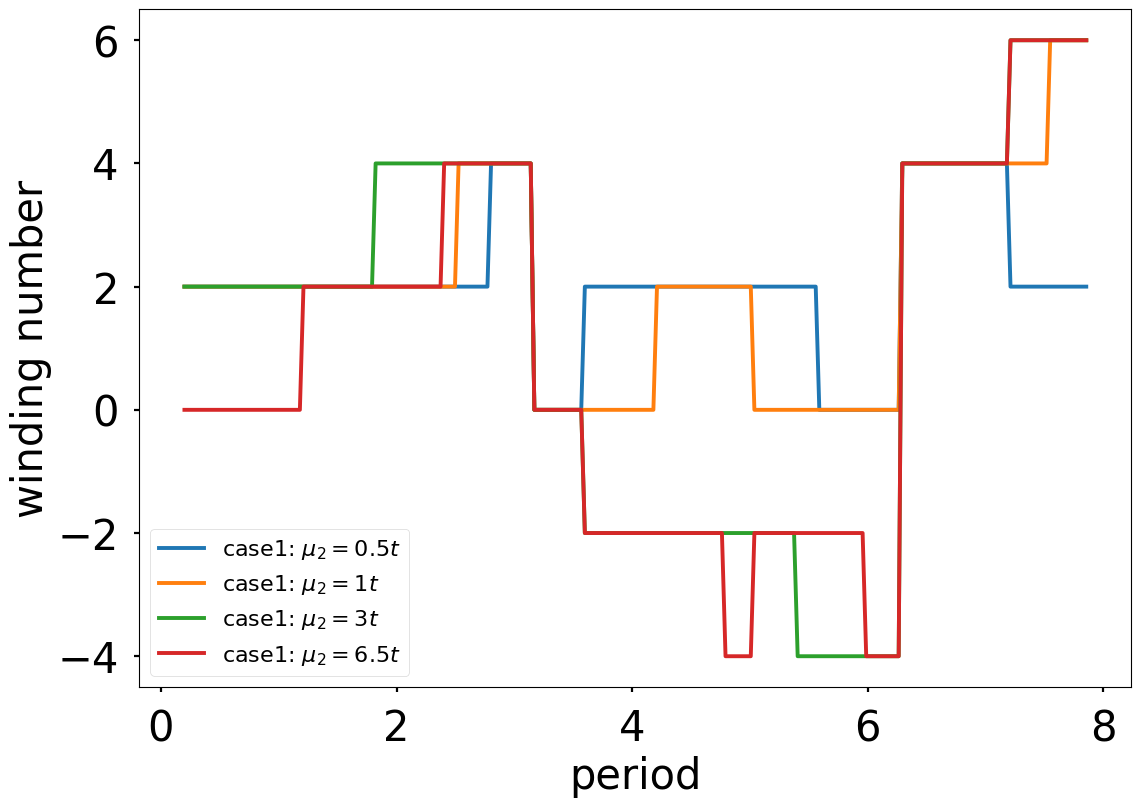

In [7]:

plt.title(f"")
for i in range(4):
    plt.plot(var_T,np.round((windings1+windings2)/2)[i]*2, label = f'case1: $\mu_2={var_mu[i]}t$')
plt.ylabel('winding number')
plt.xlabel('period')
#plt.yscale('log')
plt.legend()
plt.savefig(f'winding number zero majorana-mu1=0t mu2=different cases, delta1=delta2=t.pdf', bbox_inches = 'tight')
plt.show()


/home/eslam/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/eslam/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


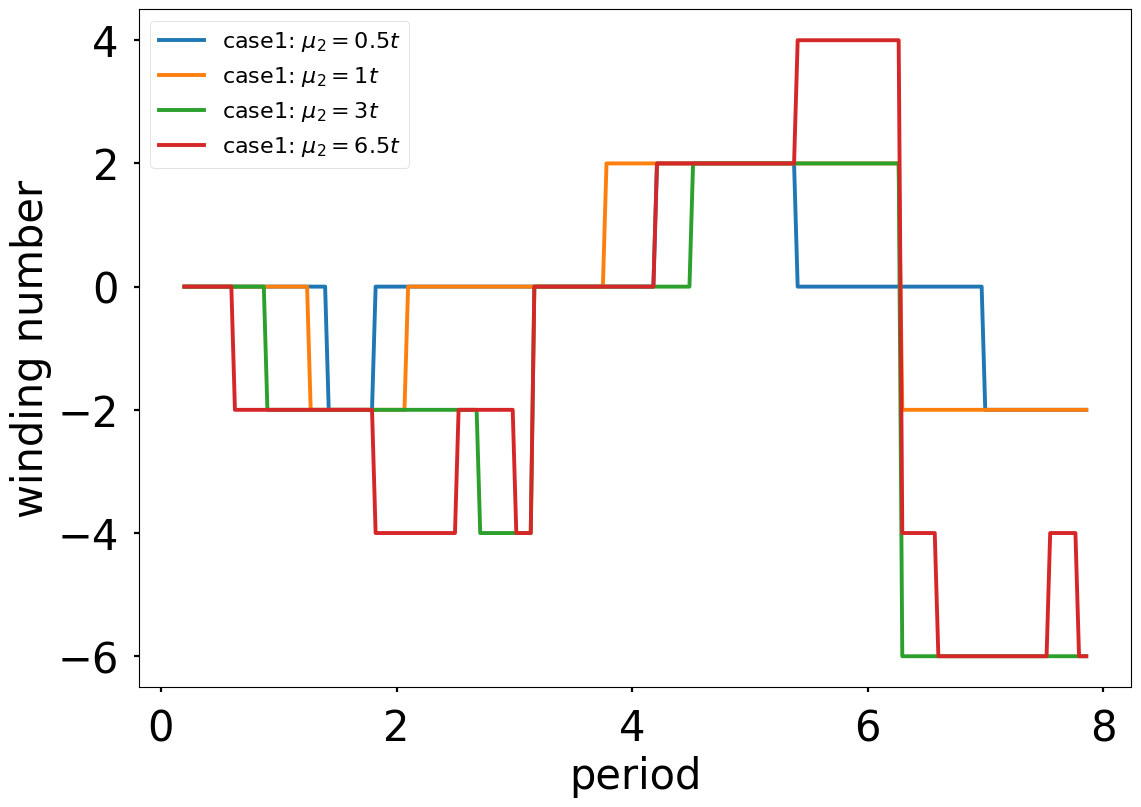

In [8]:
plt.title(f"")
for i in range(4):
    plt.plot(var_T,np.round((windings1-windings2)/2)[i]*2, label = f'case1: $\mu_2={var_mu[i]}t$')
plt.ylabel('winding number')
plt.xlabel('period')
#plt.yscale('log')
plt.legend()
plt.savefig(f'winding number pi majorana-mu1=0t mu2=different cases, delta1=delta2=t.pdf', bbox_inches = 'tight')
plt.show()
